# 0. Getting setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.5.1+cpu
torchvision version: 0.20.1+cpu


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
    from utils import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# 1. Getting data.

We trained EfficientNetB2 with 10% data and ViT with 20% data so can't compare them. let's train both on 20% data first and choose.

In [5]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")


data_20_percent_path

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [6]:
# Setup directory paths to train and test images
train_dir_20 = data_20_percent_path / "train"
test_dir_20 = data_20_percent_path / "test"

train_dir_20, test_dir_20

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

# 2. FoodVision Mini model deployment experiment outline

So our goals are:

1. Performance - A model that performs at 95%+ accuracy.
2. Speed - A model that can classify an image at ~30FPS (0.03 seconds inference time per image, also known as latency).


# 3. Creating an EffNetB2 feature extractor


In [8]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(
    weights=effnetb2_weights,
)

# 4. Freeze the base layers in the model (this will feeze all layers to begin with)
for param in effnetb2.parameters():
    param.requires_grad = False

In [9]:
# Now let's change the classifieer head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [11]:
# 5. Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

## 3.1 Create a function to make an EffNetB2 feature extractor

In [4]:
def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

In [5]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [15]:
from torchinfo import summary

# # Print EffNetB2 model summary (uncomment for full output) 
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

# 3.2 Creating DataLoaders for EffNetB2

In [17]:
from going_modular.data_setup import create_dataloader

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = create_dataloader(train_dir=train_dir_20,
                                                                                     test_dir=test_dir_20,
                                                                                     batch_size=32,
                                                                          train_transform=effnetb2_transforms,
                                                                          test_transform=effnetb2_transforms,)

## 3.3 Training EffNetB2 feature extractor

In [18]:
from going_modular.engine import train

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Set seed for reproducibility
set_seeds(seed=42)
effnetb2_results = train(
    model=effnetb2,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader_effnetb2,
    test_dataloader=test_dataloader_effnetb2,
    epochs=10,
    device=device,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9794 | train_acc: 0.5708 | test_loss: 0.7376 | test_acc: 0.9256
Epoch: 2 | train_loss: 0.7138 | train_acc: 0.8438 | test_loss: 0.5704 | test_acc: 0.9318
Epoch: 3 | train_loss: 0.5720 | train_acc: 0.8271 | test_loss: 0.4823 | test_acc: 0.9409
Epoch: 4 | train_loss: 0.4941 | train_acc: 0.8750 | test_loss: 0.4305 | test_acc: 0.9625
Epoch: 5 | train_loss: 0.4621 | train_acc: 0.8896 | test_loss: 0.3893 | test_acc: 0.9381
Epoch: 6 | train_loss: 0.3705 | train_acc: 0.9167 | test_loss: 0.3618 | test_acc: 0.9159
Epoch: 7 | train_loss: 0.3844 | train_acc: 0.8938 | test_loss: 0.3344 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.3960 | train_acc: 0.8521 | test_loss: 0.2957 | test_acc: 0.9812
Epoch: 9 | train_loss: 0.3358 | train_acc: 0.9021 | test_loss: 0.2950 | test_acc: 0.9506
Epoch: 10 | train_loss: 0.3036 | train_acc: 0.9229 | test_loss: 0.2819 | test_acc: 0.9750


## 3.4 Inspecting EffNetB2 loss curves

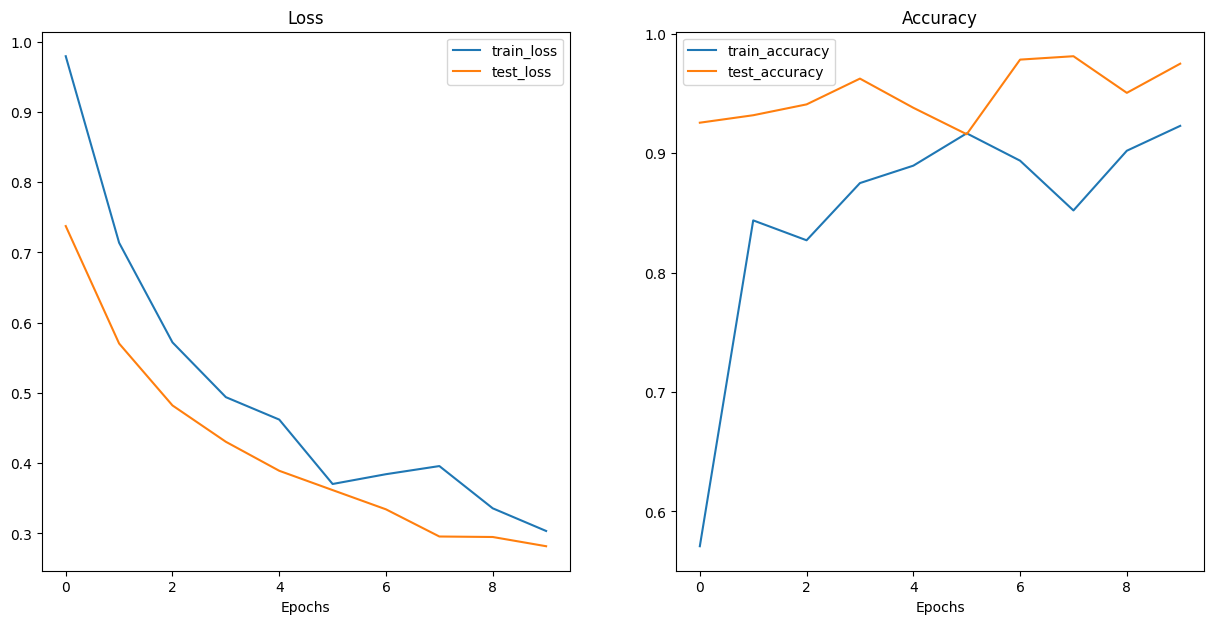

In [19]:
from utils import plot_loss_curves

plot_loss_curves(effnetb2_results)

## 3.5 Saving EffNetB2 feature extractor

In [20]:
from going_modular.utils import save_model

# Save model

model_name = "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_precent.pth"
save_model(
    model=effnetb2,
    target_dir="models",
    model_name=model_name,
)

[INFO] Saving model to: models\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_precent.pth


## 3.6 Checking the size of EffNetB2 feature extractor model

Since it's important to know where we are going to deploy our model and how much space it will take, let's check the size of the model.


In [26]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_precent.pth").stat().st_size // (1024**2)
print(f"[INFO] Model size: {pretrained_effnetb2_model_size} MB")

[INFO] Model size: 29 MB


## 3.7 Collection EffNetB2 feature extractor stats

Let's calculate total number of weights.

In [24]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
print(f"[INFO] Total parameters in EffNetB2: {effnetb2_total_params}")

[INFO] Total parameters in EffNetB2: 7705221


In [27]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.28188147246837614,
 'test_acc': 0.975,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

# 4. Creating ViT feature extractor

Let's do the same for ViT_B/16 model

In [28]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [5]:
def create_vit_model(num_classes:int=3, 
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model. 
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes
    
    return model, transforms

In [30]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

In [31]:
from torchinfo import summary

# # Print ViT feature extractor model summary (uncomment for full output)
summary(vit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## 4.1 Create DataLoaders for ViT

In [6]:
# Setup ViT DataLoaders
from going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloader(train_dir=train_dir_20,
                                                                                        test_dir=test_dir_20,
                                                                                        batch_size=32,
                                                                                        train_transform=vit_transforms,
                                                                                        test_transform=vit_transforms,)

NameError: name 'train_dir_20' is not defined

## 4.2 Training ViT feature extractor

In [33]:
from going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Train ViT model
set_seeds(seed=42)
vit_results = engine.train(
    model=vit,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader_vit,
    test_dataloader=test_dataloader_vit,
    epochs=10,
    device=device,
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2614 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.2197 | train_acc: 0.9437 | test_loss: 0.1492 | test_acc: 0.9688
Epoch: 3 | train_loss: 0.1534 | train_acc: 0.9583 | test_loss: 0.1125 | test_acc: 0.9750
Epoch: 4 | train_loss: 0.1304 | train_acc: 0.9604 | test_loss: 0.0961 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1079 | train_acc: 0.9688 | test_loss: 0.0821 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.0981 | train_acc: 0.9750 | test_loss: 0.0776 | test_acc: 0.9812
Epoch: 7 | train_loss: 0.0908 | train_acc: 0.9812 | test_loss: 0.0727 | test_acc: 0.9756
Epoch: 8 | train_loss: 0.0729 | train_acc: 0.9854 | test_loss: 0.0645 | test_acc: 0.9875
Epoch: 9 | train_loss: 0.0647 | train_acc: 0.9854 | test_loss: 0.0606 | test_acc: 0.9750
Epoch: 10 | train_loss: 0.0558 | train_acc: 0.9854 | test_loss: 0.0613 | test_acc: 0.9750


## 4.3 Inspecting ViT loss curves

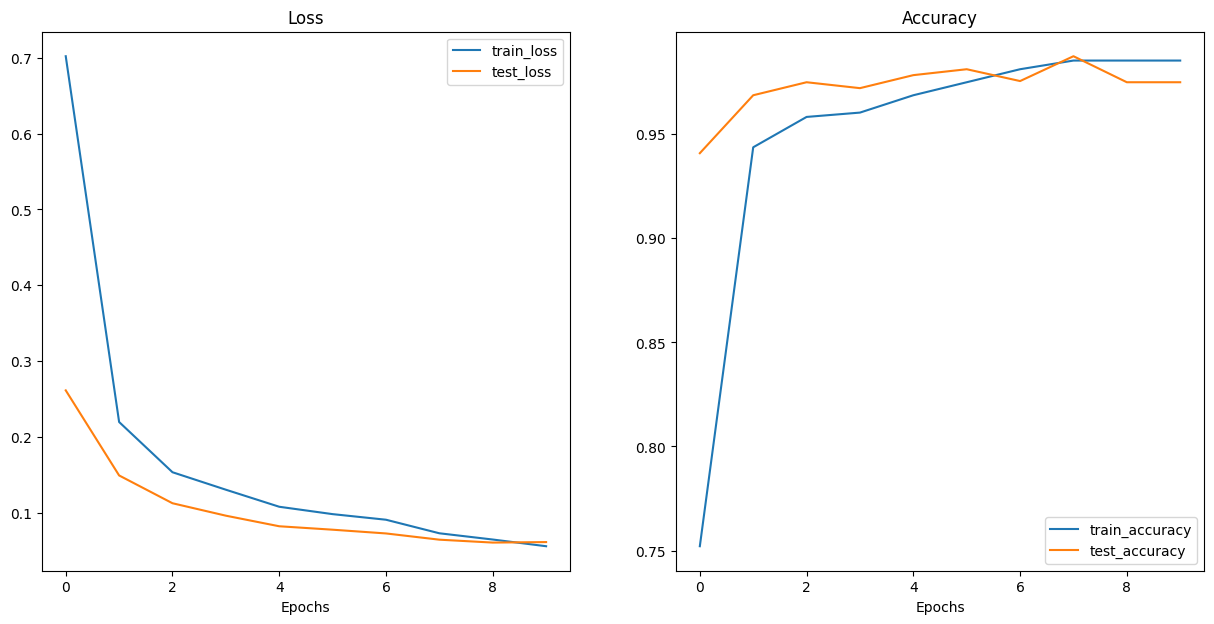

In [34]:
from utils import plot_loss_curves

plot_loss_curves(vit_results)

## 4.4 Saving ViT feature extractor

In [35]:
# Save the model
from going_modular.utils import save_model

model_name = "09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_precent.pth"
save_model(
    model=vit,
    target_dir="models",
    model_name=model_name,
)

[INFO] Saving model to: models\09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_precent.pth


## 4.5 Checking the size of ViT feature extractor

In [36]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_precent.pth").stat().st_size // (1024**2)
print(f"[INFO] Model size: {pretrained_vit_model_size} MB")


[INFO] Model size: 327 MB


## 4.6 Collecting ViT feature extractor stats

In [37]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
print(f"[INFO] Total parameters in ViT: {vit_total_params}")

[INFO] Total parameters in ViT: 85800963


In [38]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.0612976536154747,
 'test_acc': 0.975,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

# 5. Making predictions with our trained model and timing them


We know both of our models are performing at over 95% accuracy on the test dataset, but how fast are they?

Ideally, if we're deploying our FoodVision Mini model to a mobile device so people can take photos of their food and identify it, we'd like the predictions to happen at real-time (~30 frames per second).

That's why our second criteria is: a fast model.

To find out how long each of our models take to performance inference, let's create a function called pred_and_store() to iterate over each of the test dataset images one by one and perform a prediction.

We'll time each of the predictions as well as store the results in a common prediction format: a list of dictionaries (where each element in the list is a single prediction and each sinlge prediction is a dictionary)

In [40]:
from pathlib import Path

# Get all test data filepaths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir_20}")
test_data_paths = list(Path(test_dir_20).rglob("*/*.jpg"))
print(f"[INFO] Number of test data filepaths found: {len(test_data_paths)}")
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data\pizza_steak_sushi_20_percent\test
[INFO] Number of test data filepaths found: 150


[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg')]

## 5.1 Creating a function to make predicitons across the test dataset

In [41]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: torchvision.transforms, 
                   class_names: List[str], 
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    # 2. Create an empty list to store prediction dictionaries
    pred_list = []
    
    # 3. Loop through target paths
    for path in tqdm(paths):
        
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # 6. Start the prediction timer
        start_time = timer()
        
        # 7. Open image path
        img = Image.open(path)
        
        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device) 
        
        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()
        
        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample 
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on) 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
    
    # 15. Return list of prediction dictionaries
    return pred_list

## 5.2 Making and timing predictions with EffNetB2

In [42]:
# Make predictions on test data with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device=device)

  0%|          | 0/150 [00:00<?, ?it/s]

In [44]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.993,
  'pred_class': 'pizza',
  'time_for_pred': 0.1477,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.5057,
  'pred_class': 'pizza',
  'time_for_pred': 0.059,
  'correct': True}]

In [45]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9930,pizza,0.1477,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.5057,pizza,0.0590,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9929,pizza,0.0632,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7058,pizza,0.0589,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7667,pizza,0.0601,True


In [46]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     146
False      4
Name: count, dtype: int64

In [47]:
# Find the average time per prediction 
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.0587 seconds


* NOTE: Since we are using CPU for inference, the time per prediction will be slower than if we were using a GPU

In [48]:
# Add EffNetB2 average prediction time to stats dictionary 
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28188147246837614,
 'test_acc': 0.975,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.0587}

## 5.3 Making and timing predictions with ViT

In [49]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [50]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9987,
  'pred_class': 'pizza',
  'time_for_pred': 0.2624,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9961,
  'pred_class': 'pizza',
  'time_for_pred': 0.19,
  'correct': True}]

In [51]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9987,pizza,0.2624,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9961,pizza,0.1900,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9988,pizza,0.1989,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9879,pizza,0.2865,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9795,pizza,0.2119,True


In [52]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

correct
True     146
False      4
Name: count, dtype: int64

In [53]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.2042 seconds


In [54]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.0612976536154747,
 'test_acc': 0.975,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.2042}

# 6. Comparing model results, prediction times and size

In [55]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281881,97.5,7705221,29,0.0587,EffNetB2
1,0.061298,97.5,85800963,327,0.2042,ViT


In [56]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.217459,1.0,11.135432,11.275862,3.478705


## 6.1 Visualizing the speed vs. performance tradeoff

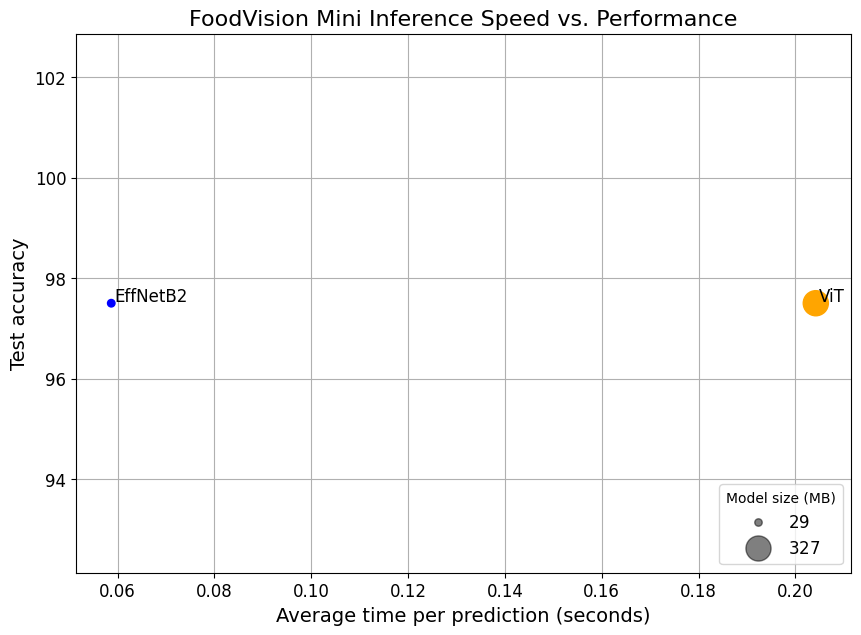

In [60]:
# 1. Create a plot from model comparision DataFrame
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(
    data=df,
    x="time_per_pred_cpu",
    y="test_acc",
    c=["blue", "orange"], # color by model
    s="model_size (MB)"
)

# 2. Add tiltles, labels and customize fontsize
ax.set_title("FoodVision Mini Inference Speed vs. Performance", fontsize=16)
ax.set_xlabel("Average time per prediction (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy", fontsize=14)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.grid(True)

# 3. Annote with model names
# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], 
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)
    
# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(
    handles,
    labels,
    title="Model size (MB)",
    loc="lower right",
    fontsize=12
)


# Save the plot
%mkdir -p images
plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()


# 7. Bringing FoodVision Mini to life by creating a Gradio Demo

In [61]:
# Import/install Gradio 
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")

Gradio version: 5.9.1


## 7.1 Creating a function to map our inputs and outpus

In [62]:
# Put EffNetB2 on CPU
effnetb2.to("cpu") 

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [63]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediciton on img and returns prediction and time taken.
    """
    
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation model and turn on inference model
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities.
        pred_probs = torch.softmax(effnetb2(img), dim=1)
        
    # Create a prediction label and prediction probability dictionary for each prediction class
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [75]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir_20).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data\pizza_steak_sushi_20_percent\test\pizza\138961.jpg

Prediction label and probability dictionary: 
{'pizza': 0.48257312178611755, 'steak': 0.24038495123386383, 'sushi': 0.2770419716835022}
Prediction time: 0.09494 seconds


## 7.2 Creating a list of example images

Gradio's Interface class takes a list of examples of as an optional parameter (gradio.Interface(examples=List[Any])).

And the format for the examples parameter is a list of lists.

So let's create a list of lists containing random filepaths to our test images.

In [99]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath) for filepath in random.sample(test_data_paths, k=3)]]
example_list

[['data\\pizza_steak_sushi_20_percent\\test\\steak\\550687.jpg',
  'data\\pizza_steak_sushi_20_percent\\test\\steak\\2365038.jpg',
  'data\\pizza_steak_sushi_20_percent\\test\\sushi\\2903621.jpg']]

## 7.3 Building a Gradio Interface

In [96]:
!pip install --upgrade gradio


  Using cached gradio-5.9.1-py3-none-any.whl.metadata (16 kB)
  Using cached gradio_client-1.5.2-py3-none-any.whl.metadata (7.1 kB)
Using cached gradio-5.9.1-py3-none-any.whl (57.2 MB)
Using cached gradio_client-1.5.2-py3-none-any.whl (320 kB)
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.3.0
    Uninstalling gradio_client-1.3.0:
      Successfully uninstalled gradio_client-1.3.0
  Attempting uninstall: gradio
    Found existing installation: gradio 4.44.0
    Uninstalling gradio-4.44.0:
      Successfully uninstalled gradio-4.44.0


In [ ]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the gradio demo
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil" ,label="Select an image of pizza, steak or sushi"),
    outputs=[
        gr.Label(num_top_classes=3, label="Prediction"),
        gr.Number(label="Prediction time (seconds)")
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article
)

# Launch the gradio demo
demo.launch(share=True,
            
            )

* Running on local URL:  http://127.0.0.1:7868

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


# 8. Turning our FoodVision Mini Gradio Demo into a deployable app

## 8.1 Creating a demos folder to store our FoodVision Mini app files

In [106]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
# If the file doesn't exist, create it anyway
foodvision_mini_demo_path.mkdir(parents=True, 
                                exist_ok=True)
    
# Check what's in the folder
!dir demos\\foodvision_mini

 Volume in drive D is New Volume
 Volume Serial Number is 6E4A-22B4

 Directory of d:\deep learning\demos\foodvision_mini

01/01/2025  07:31 PM    <DIR>          .
01/01/2025  07:31 PM    <DIR>          ..
               0 File(s)              0 bytes
               2 Dir(s)  44,070,445,056 bytes free


## 8.2 Creating a folder of example images to use with our FoodVision Mini Demo

In [107]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collcet three random images from the test data and copy them to the examples directory
random_test_image_paths = random.sample(test_data_paths, k=3)

# 3. Copy the random test images to the examples directory
for i, path in enumerate(random_test_image_paths):
    shutil.copy(path, foodvision_mini_examples_path / f"example_{i}.jpg")
    print(f"Copied {path} to {foodvision_mini_examples_path / f'example_{i}.jpg'}")

Copied data\pizza_steak_sushi_20_percent\test\sushi\3494950.jpg to demos\foodvision_mini\examples\example_0.jpg
Copied data\pizza_steak_sushi_20_percent\test\pizza\2111981.jpg to demos\foodvision_mini\examples\example_1.jpg
Copied data\pizza_steak_sushi_20_percent\test\steak\100274.jpg to demos\foodvision_mini\examples\example_2.jpg


In [108]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/example_0.jpg'],
 ['examples/example_1.jpg'],
 ['examples/example_2.jpg']]

## 8.3 Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [120]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_precent.pth"

# Create a destination path for our target model 
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")
    
    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path, 
                dst=effnetb2_foodvision_mini_model_destination)
    
    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_precent.pth to demos\foodvision_mini\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_precent.pth
[INFO] Model move complete.


## 8.4 Turning our EffNetB2 model into a Python script (model.py)

In [110]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Writing demos/foodvision_mini/model.py


## 8.5 Turning our FoodVision Mini Gradio app into a Python script(app.py)

In [111]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


## 8.6 Creating a requirements file for FoodVision Mini

In [112]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


# 9. Deploying our FoodVision Mini app to HuggingFace Spaces

## 9.1 Downloading our FoodVision Mini app files

In [121]:
!dir demos\foodvision_mini

 Volume in drive D is New Volume
 Volume Serial Number is 6E4A-22B4

 Directory of d:\deep learning\demos\foodvision_mini

01/01/2025  07:41 PM    <DIR>          .
01/01/2025  07:31 PM    <DIR>          ..
01/01/2025  03:11 PM        31,307,450 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_precent.pth
01/01/2025  07:37 PM             2,988 app.py
01/01/2025  07:33 PM    <DIR>          examples
01/01/2025  07:36 PM             1,215 model.py
01/01/2025  07:38 PM                51 requirements.txt
               4 File(s)     31,311,704 bytes
               3 Dir(s)  44,070,195,200 bytes free


In [126]:
import os
import re
import zipfile

def zip_folder_with_regex(folder_path, output_zip, exclude_regex_list):
    exclude_patterns = [re.compile(pattern) for pattern in exclude_regex_list]

    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            # Exclude directories matching regex patterns
            dirs[:] = [d for d in dirs if not any(pattern.search(d) for pattern in exclude_patterns)]

            for file in files:
                # Exclude files matching regex patterns
                file_path = os.path.join(root, file)
                if not any(pattern.search(file_path) for pattern in exclude_patterns):
                    arcname = os.path.relpath(file_path, folder_path)
                    zipf.write(file_path, arcname)

# Folder to zip
folder_to_zip = 'demos/foodvision_mini'
# Output zip file
output_zip = 'demos/foodvision_mini.zip'
# Regex patterns to exclude
exclude_regex_list = [
    r'\.pyc$',               # Exclude .pyc files
    r'\.ipynb$',             # Exclude .ipynb files
    r'__pycache__',          # Exclude __pycache__ directories
    r'ipynb_checkpoints'     # Exclude ipynb_checkpoints directories
]

# Call the function
zip_folder_with_regex(folder_to_zip, output_zip, exclude_regex_list)

print(f"Zipped folder with regex exclusions: {output_zip}")


Zipped folder with regex exclusions: demos/foodvision_mini.zip


# 10 Creating FoodVision Big

## 10.1 Creating a model and transforms for FoodVision Big

In [6]:
# Create EffNetB2 model
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

In [7]:
from torchinfo import summary

# # Get a summary of EffNetB2 feature extractor for Food101 with 101 output classes (uncomment for full output)
summary(effnetb2_food101, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [8]:
# Create food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])

food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [9]:
print(f"Training transforms:\n{food101_train_transforms}\n") 
print(f"Testing transforms:\n{effnetb2_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


10.2 Getting data for FoodVision Big

In [ ]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data/")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms, # perform normal EffNetB2 transforms on test data
                             download=True)

In [25]:
# Since we dataset is big we will use the custom dataset class as i have already downloaded the data
import os
from PIL import Image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, txt_file, transform=None):
        """
        Args:
            root_dir (str): Root directory containing image folders.
            txt_file (str): Path to the train/test.txt file containing image paths.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Parse the txt file to get image paths and labels
        with open(txt_file, 'r') as file:
            for line in file:
                path = line.strip()  # Remove any trailing whitespace/newlines
                label = path.split('/')[0]  # Extract the class name (folder name)
                self.image_paths.append(path + ".jpg")
                self.labels.append(label)

        # Create a mapping of class names to indices
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(sorted(set(self.labels)))}
        self.labels = [self.class_to_idx[label] for label in self.labels]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Get the image path and corresponding label
        img_path = os.path.join(self.root_dir, self.image_paths[idx])
        label = self.labels[idx]

        # Load the image
        image = Image.open(img_path).convert('RGB')

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label


In [26]:
# Load the training and testing data


train_data = CustomImageDataset(
    root_dir="data/food-101/images",
    txt_file="data/food-101/meta/train.txt",
    transform=food101_train_transforms
)

test_data = CustomImageDataset(
    root_dir="data/food-101/images",
    txt_file="data/food-101/meta/test.txt",
    transform=effnetb2_transforms
)

In [27]:
# Let's check the length of the training and testing data
print(f"Training data length: {len(train_data)}")
print(f"Testing data length: {len(test_data)}")

Training data length: 75750
Testing data length: 25250


In [41]:
food101_class_names = train_data.class_to_idx

# View the first 10 class names
list(food101_class_names.keys())[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

####  We are not going to create a subset but train on whole datset

## 10.4 Turning our Food101 datasets into `DataLoader's`

In [42]:
import os
import torch

BATCH_SIZE = 32 

# Create DataLoader instances for training and testing data
train_dataloader_food101 = torch.utils.data.DataLoader(train_data, 
                                                       batch_size=BATCH_SIZE, 
                                                       shuffle=True, 
                                                       num_workers=2)

test_dataloader_food101 = torch.utils.data.DataLoader(test_data,
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False,
                                                        num_workers=2)



## 10.5 Training FoodVision Big Model

In [ ]:
from going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(
    params=effnetb2_food101.parameters(), 
    lr=1e-3
)

# Setup loss function
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

# Train EffNetB2 on Food101
set_seeds(seed=42)
effnetb2_food101_results = engine.train(
    model=effnetb2_food101,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader_food101,
    test_dataloader=test_dataloader_food101,
    epochs=30,
    device=device,
)

  0%|          | 0/30 [00:00<?, ?it/s]

## 10.6 Inspecting los curves of FoodVision BigModel

In [ ]:
from utils import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_results)